## <span style="color:red">ML-K-Means</span>

## Import Libraries

In [32]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline


## Load the Data

In [33]:
df_football = pd.read_csv("final_data.csv")

In [34]:
df_football.shape

(10754, 22)

In [35]:
df_football.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [36]:
# uniqeness
df_football.drop_duplicates(inplace=True)
df_football[df_football.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [37]:
# Completeness
df_football.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [38]:
# Accurecy types
df_football.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [39]:

df_football.drop("player", axis=1, inplace=True)
#df_football.drop("team", axis=1, inplace=True)
df_football.drop("position", axis=1, inplace=True)
df_football.drop("name", axis=1, inplace=True)

In [40]:
df_football.head(2)

,team,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [41]:
# Convert categorical variables using OneHotEncoding
categorical_features = ['team'] #

numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards',
                    'second yellow cards','red cards', 'goals conceded','clean sheets',
                    'naminutes played', 'days_injured','games_injured', 'award',
                    'current_value',"highest_value","position_encoded"
                    "winger"]

In [42]:
for i in categorical_features:
    print (df_football[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64


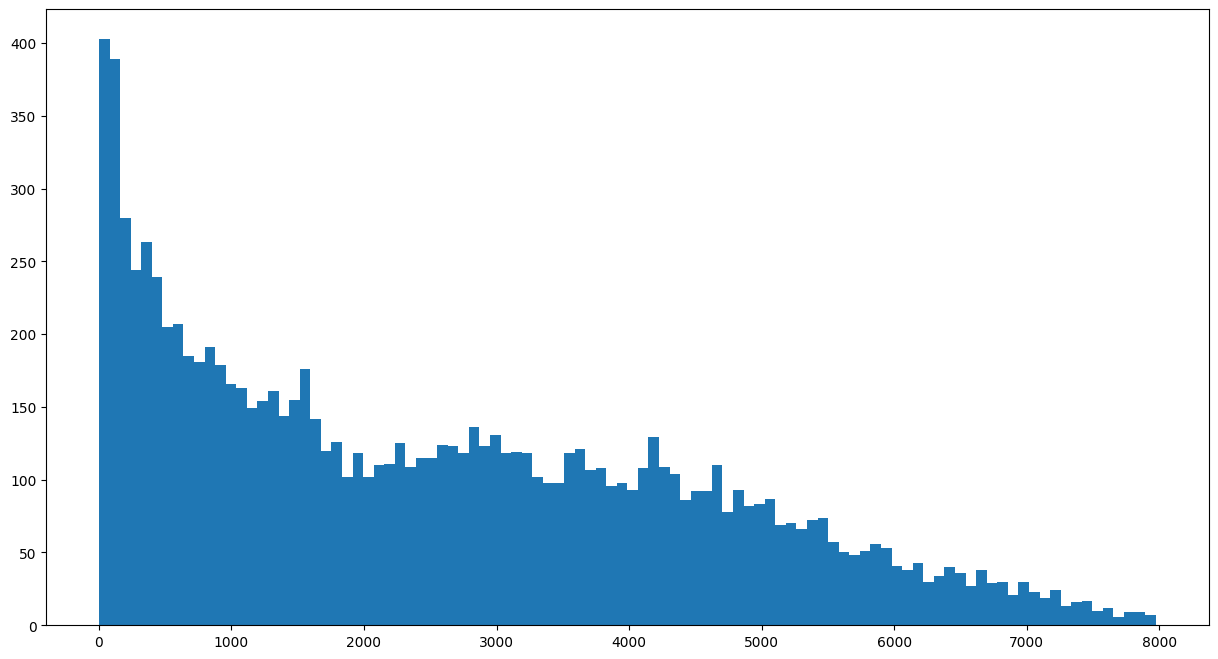

In [43]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['minutes played']);
plt.hist(df_football[(df_football['minutes played']<=8000) & (df_football['minutes played']>0)]['minutes played'],bins=100);


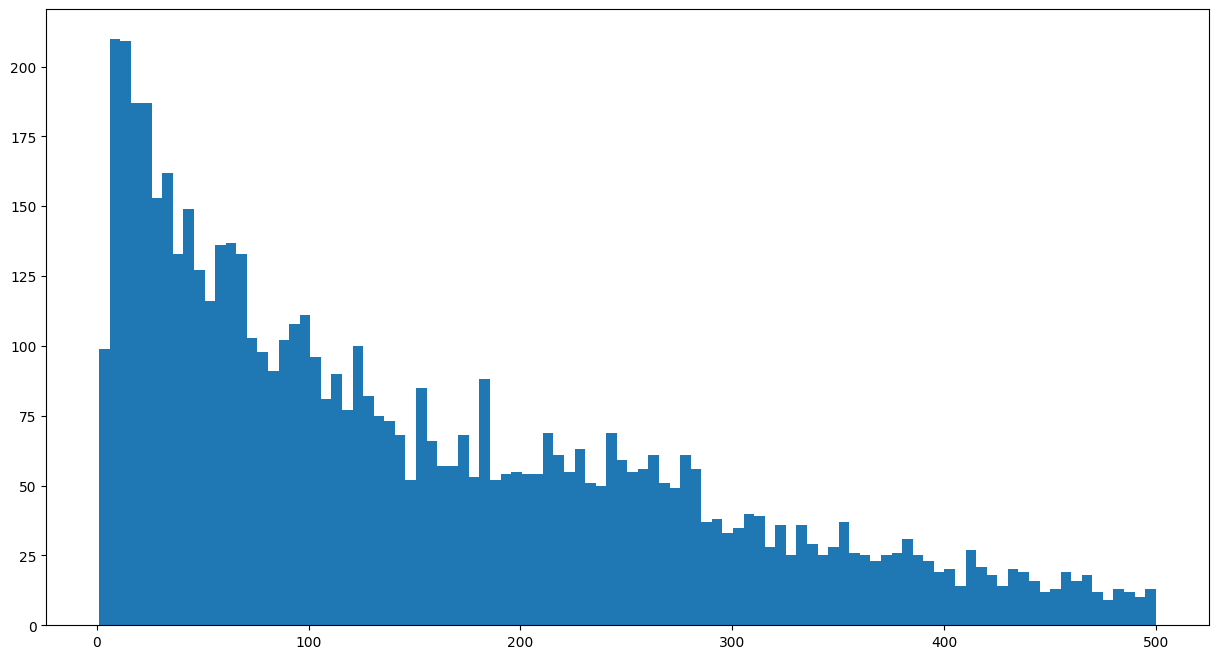

In [44]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['days_injured']);
plt.hist(df_football[(df_football['days_injured']<=500) & (df_football['days_injured']>0)]['days_injured'],bins=100);


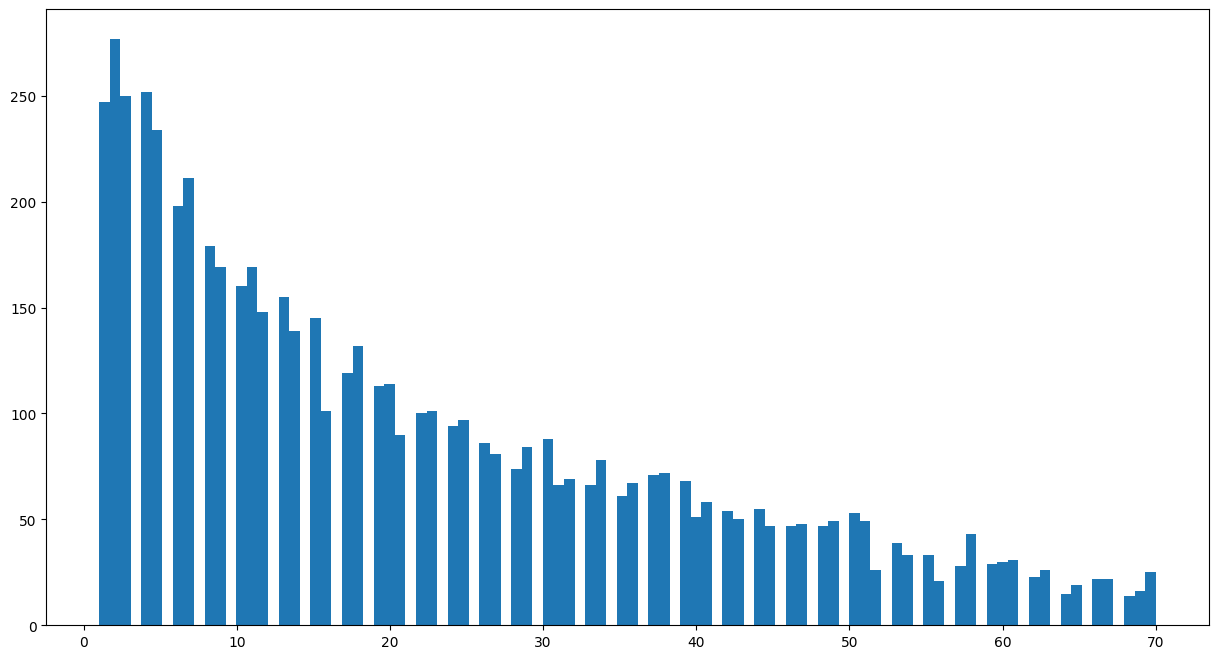

In [45]:

plt.figure(figsize=(15,8))
#plt.boxplot(df_football['games_injured']);
plt.hist(df_football[(df_football['games_injured']<=70) & (df_football['games_injured']>0)]['games_injured'],bins=100);


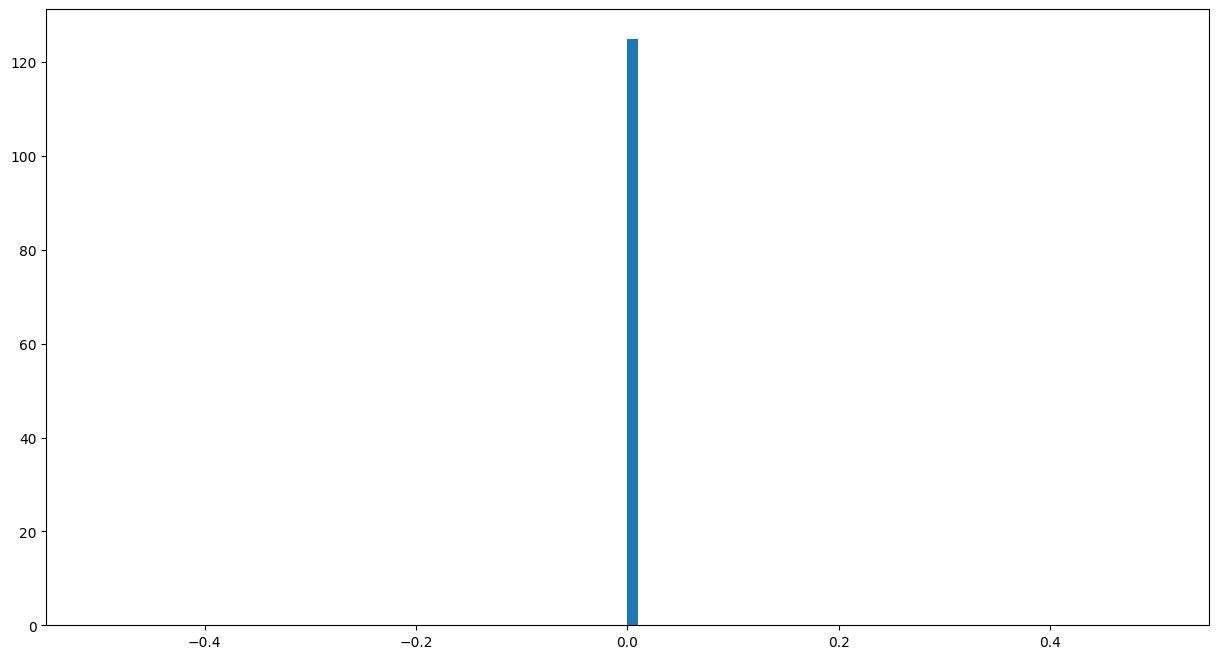

In [46]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['highest_value']);
plt.hist(df_football[(df_football['highest_value']<=0.30) & (df_football['highest_value']>-0.01)]['highest_value'],bins=100);


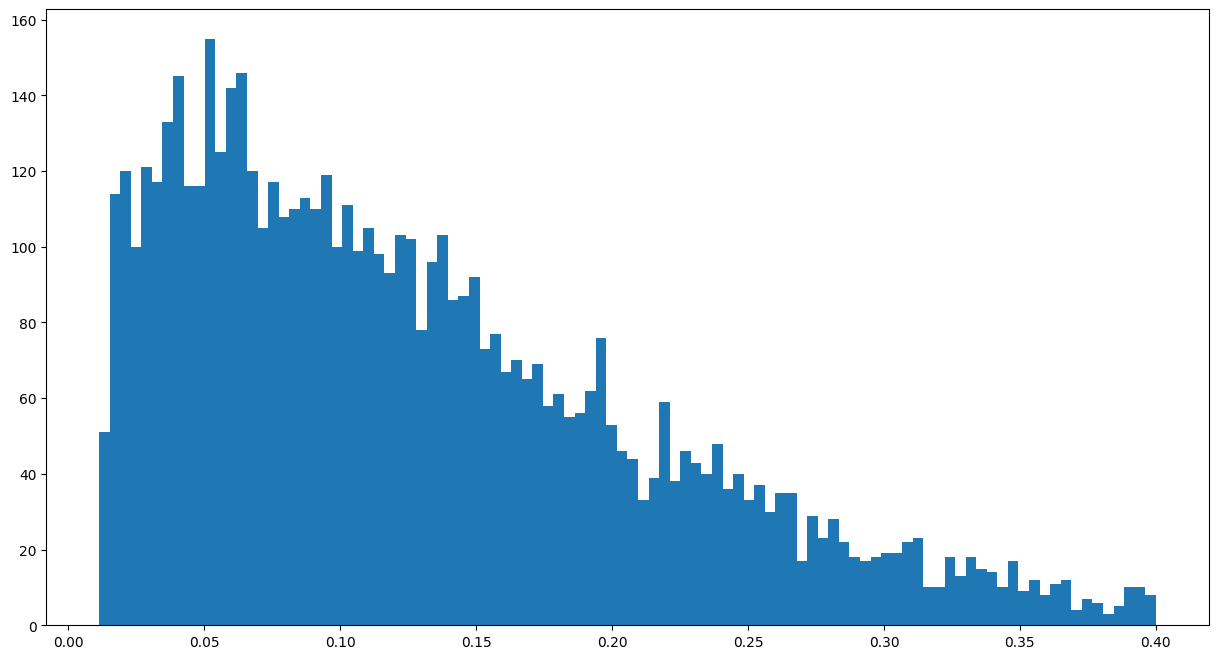

In [47]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['assists']);
plt.hist(df_football[(df_football['assists']<=0.4) & (df_football['assists']>0.0)]['assists'],bins=100);


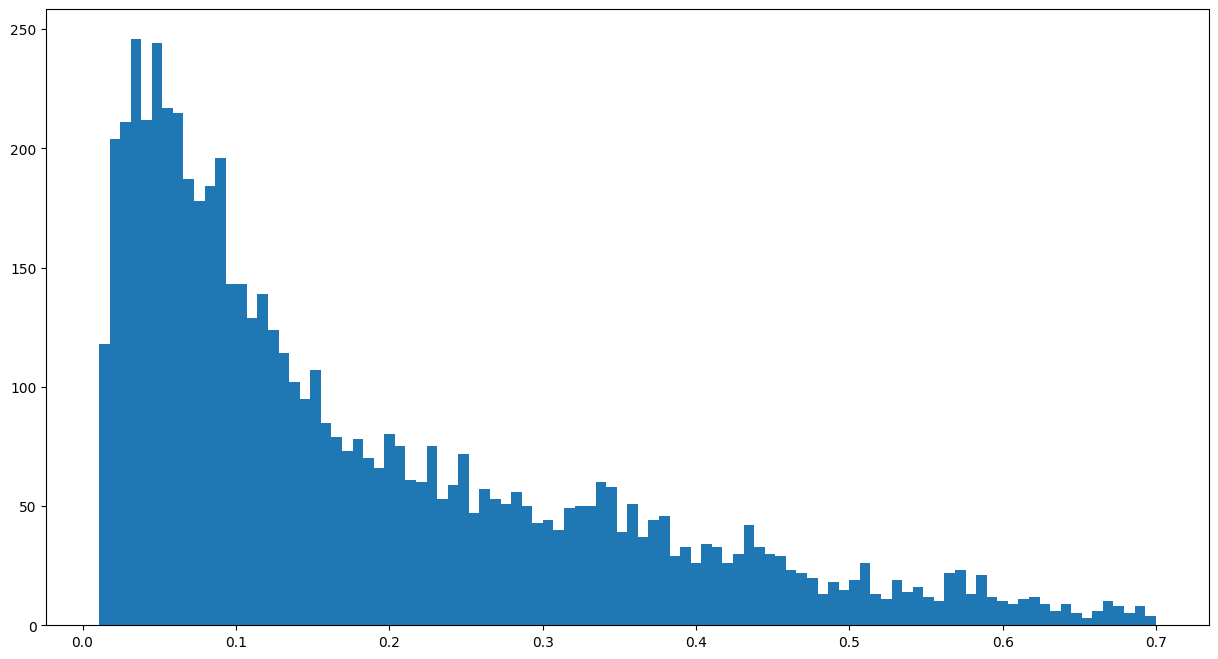

In [48]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['goals'])
plt.hist(df_football[(df_football['goals']<0.7) & (df_football['goals']>0)]['goals'], bins=100);

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [49]:
df_football.head(2)

,team,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [50]:
categorical_features

['team']

In [51]:
# one hot coding
df_football = pd.get_dummies(df_football, columns=categorical_features)

In [52]:
df_football.shape

(10754, 392)

In [53]:
df_football.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,team_West Ham United,team_Western Sydney Wanderers,team_Western United FC,team_Wigan Athletic,team_Wolfsberger AC,team_Wolverhampton Wanderers,team_Yokohama F. Marinos,team_Yokohama FC,team_Zenit St. Petersburg,team_Ümraniyespor
0,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,...,False,False,False,False,False,False,False,False,False,False
1,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,...,False,False,False,False,False,False,False,False,False,False


In [54]:
# Calculate the 35th and 75th percentiles of the price
p20 = df_football['current_value'].quantile(0.20)
p50 = df_football['current_value'].quantile(0.50)

# Function to categorize prices
def categorize_price(current_value):
    if current_value < p20:
        return 'Average Player'
    elif current_value < p50:
        return 'Good Player'
    else:
        return 'Professional Player'

# Apply the function to create a new column
df_football['player_leval_category'] = df_football['current_value'].apply(categorize_price)

df_football.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df_football['player_leval_category'].value_counts())

player_leval_category
Professional Player    5474
Good Player            3483
Average Player         1797
Name: count, dtype: int64


In [55]:
p20 , p50

(200000.0, 800000.0)

In [56]:
encoder = LabelEncoder()
df_football['player_leval_category_encoded'] = encoder.fit_transform(df_football['player_leval_category']) 

#### 3. Feature selection

In [57]:
correlation = df_football.corr(numeric_only=True)
print(correlation['player_leval_category_encoded'].sort_values(ascending=False))

player_leval_category_encoded    1.000000
appearance                       0.510054
minutes played                   0.476818
highest_value                    0.348312
games_injured                    0.236885
                                   ...   
team_Chippa United              -0.082472
team_Al-Batin FC                -0.086800
team_Marumo Gallants FC         -0.087575
team_Royal AM FC                -0.091262
goals conceded                  -0.123540
Name: player_leval_category_encoded, Length: 392, dtype: float64


In [58]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_leval_category_encoded']) > \
threshold]['player_leval_category_encoded'].index
selected_features

Index(['appearance', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'player_leval_category_encoded'],
      dtype='object')

In [59]:
selected_features = ['appearance', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'player_leval_category_encoded']
     

In [60]:
df_football = df_football[selected_features]
df_football.head()

,appearance,minutes played,days_injured,games_injured,award,highest_value,player_leval_category_encoded
0,104,9390,42,5,13,70000000,2
1,15,1304,510,58,1,22000000,2
2,4,292,697,84,4,6000000,1
3,82,6408,175,22,9,50000000,2
4,63,5031,238,51,21,80000000,2


#### 4. Prepare train and test data

In [61]:
# Prepare data
X = df_football.drop(['player_leval_category_encoded'], axis=1)


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Buliding the Model

In [62]:
wcss = []
for i in range(1, 20):  # Test 1 to 12 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=12,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

  File "c:\Users\Raghad Alharbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


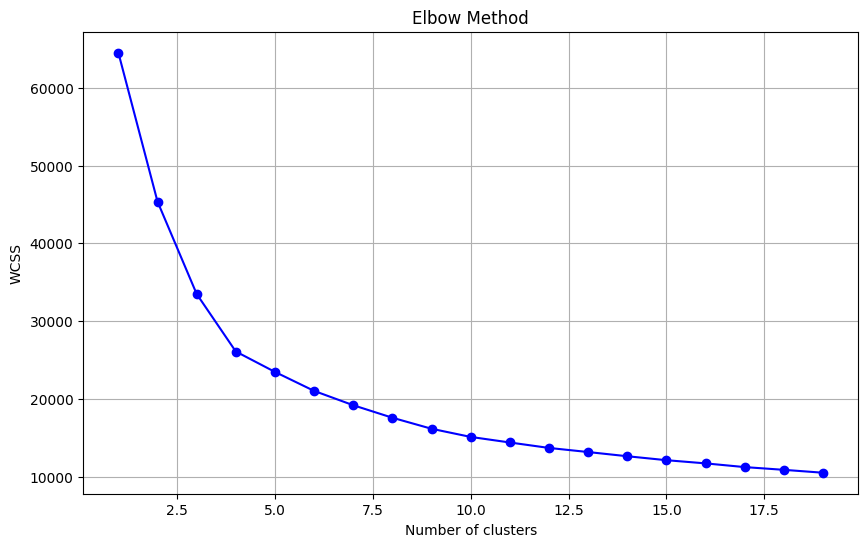

In [63]:
# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [64]:
# Optional: Apply k-Means using the optimal number of clusters
optimal_clusters = 4 # This might change based on your actual elbow curve analysis
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

### Train the Model

In [65]:
# Fit the model on the training data
y_pred = model.fit_predict(X_scaled)

## Evaluating the Model

In [66]:
X.head(2)

,appearance,minutes played,days_injured,games_injured,award,highest_value
0,104,9390,42,5,13,70000000
1,15,1304,510,58,1,22000000


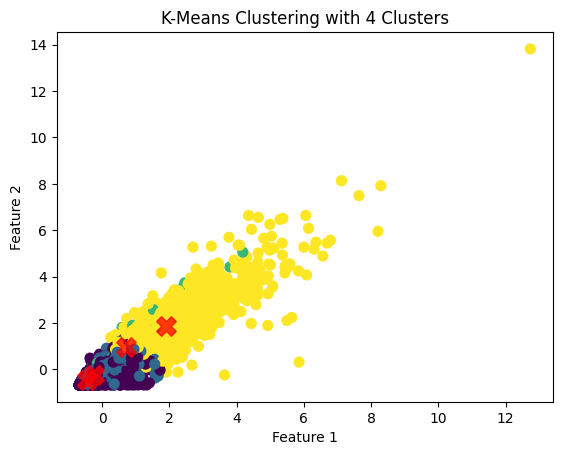

In [67]:
# Plotting the clusters with optimal number
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [68]:
X['kmeans'] = y_pred

In [69]:
X['kmeans'].value_counts()

kmeans
0    5057
1    3812
3    1524
2     361
Name: count, dtype: int64

In [70]:
X[X['kmeans']==0]

,appearance,minutes played,days_injured,games_injured,award,highest_value,kmeans
8,34,2758,47,13,0,2000000,0
20,39,2788,0,0,1,800000,0
28,34,1030,90,15,1,7000000,0
29,24,1700,135,12,0,50000000,0
56,31,2790,89,14,0,3500000,0
...,...,...,...,...,...,...,...
10749,16,1023,0,0,0,75000,0
10750,26,1449,102,18,0,300000,0
10751,20,960,0,0,0,50000,0
10752,17,865,0,0,0,50000,0


<Axes: xlabel='highest_value', ylabel='minutes played'>

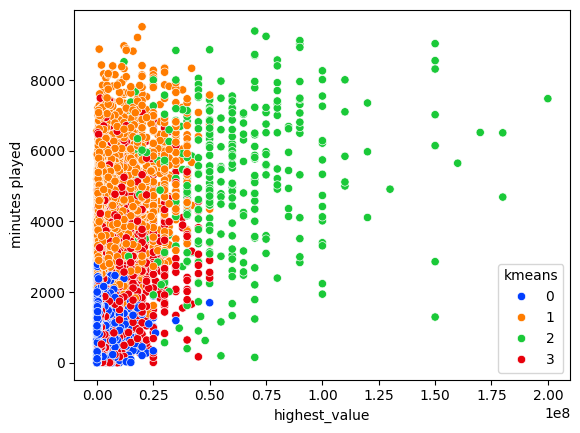

In [74]:
sns.scatterplot(data=X, x='highest_value', y='minutes played', hue='kmeans', palette='bright')

<Axes: xlabel='highest_value', ylabel='appearance'>

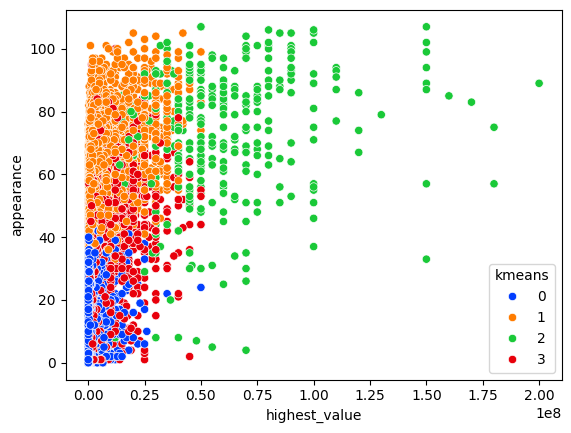

In [75]:
sns.scatterplot(data = X , x = 'highest_value', y = 'appearance', hue = 'kmeans',palette='bright')